# PlaygroundML
---
# 5. Gaussian Processes

In [1]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt

from gaussian_process import GaussianProcess, rbf_kernel, linear_kernel

# Set latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

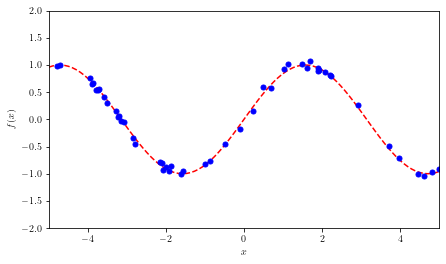

In [69]:
# Define synthetic train data
true_x = np.linspace(-5, 5, 100)
true_f = lambda x: np.sin(x)
noisy_f = lambda x: true_f(x) + np.random.normal(0, 0.05, x.shape[0])

n_trainpoints = 50
x_train = np.random.uniform(-5, 5, n_trainpoints)
y_train = noisy_f(x_train)

plt.figure(figsize=(7, 4))
plt.plot(true_x, true_f(true_x), 'r--', label='$f(x)$')
plt.plot(x_train, y_train, color='b', marker='o', markersize=5, linestyle='None')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-5, 5)
plt.ylim(-2, 2)
plt.show()

(500, 500)


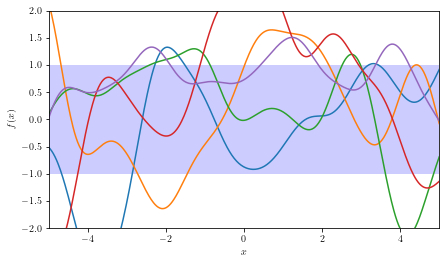

In [70]:
# Define the kernel and mean functions
sigma = 0.75
kernel = rbf_kernel(sigma)
mu = lambda x: np.zeros(x.shape)
noise = 0.05

# Define the Gaussian process
x_test = np.linspace(-5, 5, 500)
mu_x = mu(x_test)
gp = GaussianProcess(mu, kernel, noise)
f_prior, std = gp.get_prior(x_test, n_samples=5)

# Plot prior samples
plt.figure(figsize=(7, 4))
plt.plot(x_test, f_prior)
plt.fill_between(x_test, mu_x - std, mu_x + std, color='b', alpha=0.2, edgecolor=None)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(-5, 5)
plt.ylim(-2, 2)
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


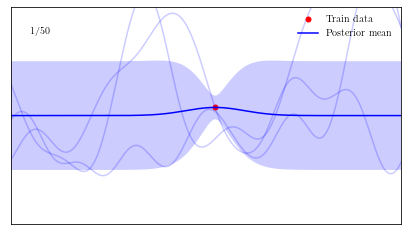

In [71]:
n_posterior_samples = 3

# Plot gif of posterior samples where one point is added at each iteration
def animate(i):
    gp = GaussianProcess(mu, kernel, noise)
    mean, Cov = gp.get_posterior(x_train[:i+1], y_train[:i+1], x_test)
    posterior_samples = np.random.multivariate_normal(mean, Cov, n_posterior_samples)
    std = np.sqrt(np.diag(Cov))

    plt.cla()
    # plt.plot(true_x, true_f(true_x), 'r--', label='$f(x)$')
    plt.plot(x_train[:i+1], y_train[:i+1], color='r', marker='o', markersize=5, linestyle='None', label='Train data')
    plt.plot(x_test, mean, 'b-', label='Posterior mean')
    plt.fill_between(x_test, mean - std, mean + std, color='b', alpha=0.2, edgecolor=None)
    plt.plot(x_test, posterior_samples.T, 'b-', alpha=0.2)
    plt.text(-4.5, 1.5, f'{i+1}/{n_trainpoints}')
    # plt.xlabel('$x$')
    # plt.ylabel('$f(x)$')
    plt.xlim(-5, 5)
    plt.ylim(-2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.legend(frameon=False, loc='upper right')
    
# Plot gif of posterior samples where one point is added at each iteration
from matplotlib import animation

fig = plt.figure(figsize=(7, 4))
anim = animation.FuncAnimation(fig, animate, frames=n_trainpoints, interval=100)

# Save as gif
anim.save('gp.gif', writer='imagemagick', fps=10, dpi=600)